In [1]:
import numpy as np
import random
import chess
from chess.pgn import read_game
from IPython.display import SVG
import tensorflow as tf
import itertools
from copy import copy

In [2]:
def pad_bitmask(mask):
    mask = [int(s) for s in list(bin(mask)[2:])]
    while len(mask)<64:
        mask.insert(0,0)
    return np.array(mask)

def bitmask_to_array(mask):
    array = pad_bitmask(mask).reshape((8,8))
    return array

def board_generator(pgn):
    while True:
        game = read_game(pgn)
        if game and len(list(game.main_line()))>0:
            node = game
            move_number = np.random.randint(0, high=len(list(game.main_line())) - 1) #don't take the last move
            while 2*(node.board().fullmove_number-1)+int(not node.board().turn) < move_number:
                next_node = node.variation(0)
                node = next_node
            yield node.board()
        else:
            pgn.seek(0)

def get_feature_matrix(board, flip_to_white_to_play=True):
    feature_matrix = np.zeros((len(chess.PIECE_TYPES)+3, len(chess.COLORS), 64))

    for piece in chess.PIECE_TYPES:
        for color in chess.COLORS:
            feature_matrix[piece, int(color),:] = pad_bitmask(board.pieces_mask(piece, color))
    if board.ep_square:
        feature_matrix[piece+1, int(not(board.turn)), -board.ep_square-1] = 1
    for color in chess.COLORS:
        feature_matrix[piece+2, int(color), :] = pad_bitmask(board.castling_rights)

    feature_matrix = feature_matrix.reshape(((8, 8, len(chess.PIECE_TYPES)+3, len(chess.COLORS))))
    
    if flip_to_white_to_play and not board.turn:
        feature_matrix = feature_matrix[::-1,::-1,:,::-1]
    
    feature_matrix = feature_matrix.reshape(((8, 8, (len(chess.PIECE_TYPES)+3) * len(chess.COLORS))))
    return feature_matrix

def make_random_move(board):
    random_move = random.choice(list(board.legal_moves))
    board.push(random_move)
    return board

def batch_generator(pgn, batch_size):
    boards = board_generator(pgn)
    batch = []
    for idx, board in enumerate(boards):
        make_random_move(board)
        batch.append(board)
        if (idx+1)%batch_size == 0:
            yield batch
            batch = []

def get_candidate_boards(board):
    candidate_boards = []
    for candidate_move in list(board.legal_moves):
        candidate_board = copy(board)
        candidate_board.push(candidate_move)
        candidate_boards.append(candidate_board)
    return candidate_boards

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [49]:
input_matrix = tf.placeholder(tf.float32, shape=[None,8,8,18])

W_conv1 = weight_variable([3, 3, 18, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(input_matrix, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([2, 2, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([2 * 2 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 2*2*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 1])
b_fc2 = bias_variable([1])

J = tf.nn.tanh(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
weights = [W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2]
var_grad = tf.gradients(J, weights)

In [50]:
batch_size = 256
num_moves = 12
_lambda = .7
lr = .001

with tf.Session() as sess:
    tf.initialize_all_variables().run()
    pgn = open("/Users/adam/Downloads/millionbase-2.22.pgn")
    batches = batch_generator(pgn, batch_size)
    
    for i, batch in enumerate(batches):
        print('batch number:', i)
        outer_sums = []
        for board in batch:
            board_seq = [board]
            J_0 = sess.run(J, feed_dict={input_matrix: [get_feature_matrix(board)], keep_prob: 1.0})[0][0]
            J_seq = [J_0]
            grad_seq = []
            for move_number in range(num_moves):
                candidate_boards = get_candidate_boards(board_seq[move_number])
                if len(candidate_boards):
                    candidate_feature_matrices = np.array([get_feature_matrix(candidate_board) for candidate_board in candidate_boards])

                    Js = sess.run(J, feed_dict={input_matrix: candidate_feature_matrices, keep_prob: 1.0})

                    J_max = np.max(Js)
                    J_seq.append(J_max)

                    J_argmax = np.argmax(Js)
                    board_seq.append(candidate_boards[J_argmax])

                    grad = sess.run(var_grad, feed_dict={input_matrix: [candidate_feature_matrices[J_argmax]], keep_prob: 1.0})
                    grad_seq.append(grad)
                else:
                    if board_seq[-1].turn:
                        J_seq.append(-1)
                    else:
                        J_seq.append(1)
                    board_seq.append(board_seq[-1])
                    grad_seq.append(grad)
                
            outer_sum=0
            diffs = np.array(J_seq[1:]) - np.array(J_seq[:-1])
            for t, grad in enumerate(grad_seq):
                inner_sum = sum([diff * _lambda**(j-t) for j, diff in enumerate(diffs[t:])])
                outer_sum += np.array(grad)*inner_sum
            outer_sums.append(outer_sum)
        mean_outer_sum = np.array(outer_sums).mean(axis=0)
        for weight, update in zip(weights, mean_outer_sum):
            weight += lr + update
        print(np.absolute(np.array([w.sum() for w in mean_outer_sum])).sum())

batch number: 0
13.8122
batch number: 1
47.3668
batch number: 2
13.2763
batch number: 3
15.1296
batch number: 4
4.54171
batch number: 5
19.8767
batch number: 6
19.7653
batch number: 7
6.59646
batch number: 8
19.2407
batch number: 9
21.8664
batch number: 10
10.5356
batch number: 11
13.8739
batch number: 12
14.898
batch number: 13
19.0734
batch number: 14
4.53538
batch number: 15
21.3374
batch number: 16
12.4113
batch number: 17
12.7048
batch number: 18
16.5464
batch number: 19
13.7783
batch number: 20


KeyboardInterrupt: 

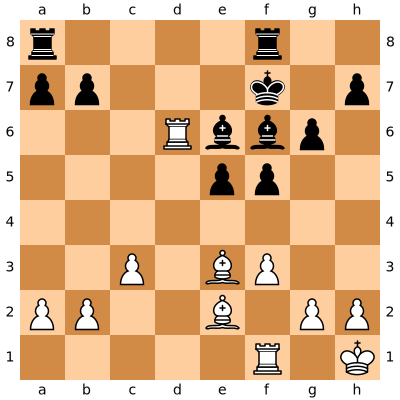

In [51]:
board